# Finding Patterns in Observed Exoplanets and Their Host Stars

### DATA 311 | T02 | Patrick Harrison

<hr>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('astro') # Comment out if don't have this mpl style sheet

from mysql import connector
from mysql.connector import Error

In [2]:
# Connect to MySQL Server
try:
    db = connector.connect(
        host="localhost",
        user="root",
        password="root",
        database="koi")
    if db.is_connected():

        db_server_info = db.get_server_info()
        print("Connected to MySQL database schema:", db.database)

        # Create a cursor object
        c = db.cursor()

except Error as e:
    print("Error while connecting to MySQL", e)

Connected to MySQL database schema: koi


### Question 1: Do host stars of confirmed exoplanets follow a luminosity and temperature distribution different from total stars? What About between different number of exoplanets?

**Background**

To perform answer this question, we will need a Hertzsprung-Russell (HR) diagram. This shows the distribution of the type of stars based on their temperature and luminosity.

Since we are not given the Luminosity of the star we need to take advantage of the stephan boltzman law and use the relationship between Luminosity, Radius and effective temperature. [1]
$$ L = 4\pi R^2\sigma T^4_{eff} $$
Here $\sigma$ is the stefen-Boltzmann constant, $R$ is the radius and $T_{eff}$ the effective temperature. We will create a function that will evaluate this realtionship.

From our data, our temperture is in $[k]$ which is proper, but we need values for the stefan-boltzmann constant in SI and the radius of our sun $[R_\odot]$. `koi_srad` is in solar radii units so we need to convert that into SI units of $[m]$

**The Query**

The SQL query needs to pull the radius and the temperature for each star we want. We will make sure that the disposition of the transit object is "CONFIRMED" and we will also return the count of unique transit objects that orbit the star.

The query should return an output in the form:

| `koi_srad` | `koi_steff` | count(`kepoi_name`) |
| --- | --- | --- |
| float(xxx) $[R_\odot]$| float(xxx) $[k]$ | int(xxx) |

The counts will need to be a join with the left table being the `Stellar_Objects` and the right table being the `Transit_Properties` table. In this case we want the counts so all instances of the right table but only the radius and temperature once for each star so we will use a LEFT JOIN. We will also group the `Transit_Properties` table by the kepid (Host) star. This will allow us to count the number of transit objects (identified by `kepoi_name`) based on the host star (`kepid`).

In [3]:
queryQ1 = """
SELECT koi_srad, koi_steff, COUNT(tp.kepoi_name)
FROM Stellar_Objects AS so
LEFT JOIN transit_properties AS tp
ON (so.kepid = tp.kepid)
WHERE tp.kepid IN (SELECT kepid FROM koi_disposition
                    WHERE koi_disposition="CONFIRMED")
GROUP BY tp.kepid
"""

In [4]:
# Execute MySQL queries
c.execute(queryQ1)
radTempCount = c.fetchall()

The luminosity for each star needs to be computed. To do this we will define a function that takes the radius in $R_\odot$ and the temperature in Kelvin.

In [5]:
def lum(radius, temp):
    """ Radius in solar radii, temp in kalvin gives luminosity of
        a star. params must be numpy arrays
    """
    sbConst = 5.67051E-8 # J m^{-2} s^{-1} K^{-4}
    Solar_Radius = 6.9598E8 # m

    return (4*np.pi)*(radius*Solar_Radius)*(radius*Solar_Radius)*sbConst*temp**4

Lets now put all these stars on the HR diagram. First we need to transpose these results though. This way we will have a list of the list of the radius, the temperature and the count.

In [6]:
radTempCount_T = tuple(zip(*radTempCount))

# Split them up and make them a numpy array
radius = np.array(radTempCount_T[0])
temp = np.array(radTempCount_T[1])
count = radTempCount_T[2]

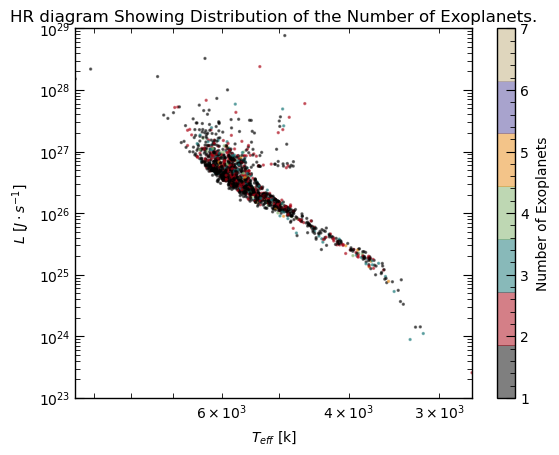

In [7]:
# Plot
fig = plt.figure()
ax = plt.gca()

ax.set_title('HR diagram Showing Distribution of the Number of Exoplanets.')
ax.set_xlabel("$T_{eff}$ [k]")
ax.set_ylabel("$L$ $[J\cdot s^{-1}]$")

cmap = mpl.colors.ListedColormap(['k', '#aa0011', '#127475', '#7fb069', 
                                  '#E98a15', '#52489c', '#c1ae7c'])

plot = ax.scatter(temp, lum(radius,temp), 
                  s=2, 
                  c=count, 
                  alpha=0.5, 
                  cmap=cmap)

#ax.legend()
fig.colorbar(plot, label="Number of Exoplanets");
ax.set_xlim(max(temp),min(temp)) # invert x axis
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_aspect=1

Lets Now look at the total stars that were observed. 

In [8]:
HR_totalStars = """
SELECT koi_srad, koi_steff
FROM Stellar_Objects
"""
# Execute MySQL queries
c.execute(HR_totalStars)
totalStars_forHR = c.fetchall()

In [9]:
totalStars_forHR_T= tuple(zip(*totalStars_forHR))

radiusTotalStars = np.array(totalStars_forHR_T[0])
tempTotalStars = np.array(totalStars_forHR_T[1])

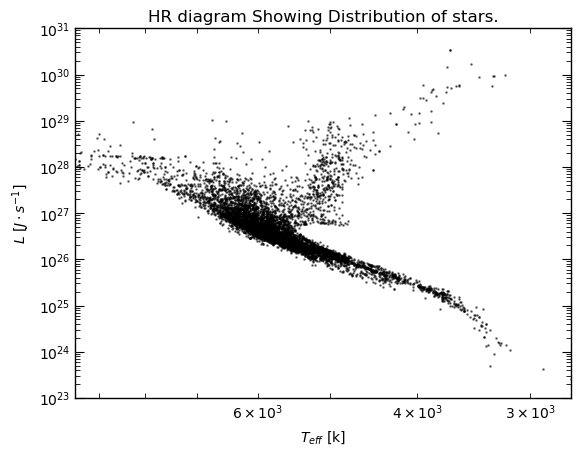

In [10]:
# Plot
fig = plt.figure()
ax = plt.gca()

ax.set_title('HR diagram Showing Distribution of stars.')
ax.set_xlabel("$T_{eff}$ [k]")
ax.set_ylabel("$L$ $[J\cdot s^{-1}]$")

ax.scatter(tempTotalStars, lum(radiusTotalStars,tempTotalStars), 
                  s=0.75, 
                  c='k', 
                  alpha=0.5)

ax.set_xlim(max(temp),min(temp)) # invert x axis
ax.set_xscale('log')
ax.set_yscale('log')

By a visual inspection, the number of stars that have exoplanets are more confined to the main sequence. The giant and super giant groups (top right) are more populated when we don't have the constraint of only confirmed tansit objects.

The general distribution of the stars in the HR diagram is consitent with the general population of stars in the observable universe. This eliminates an observational bias towards a higher count of main sequence stars observed compared to the giant branch. It is worth noting however, that the white dwarf group is not present in this HR diagram, this could be die to the relative difficulty of observing them.

### Question 2: Is there a relationship between stellar and planetary radius?

**Background**

A relationship between the stellar radius and the planetary radius could be useful. The stellar radius is easier to measure then the transit object. Thus finding exoplanets planets around certain radi stars may be more likely.


**The Query**

This query will involve pulling the stellar radius from the `stellar_objects` table and aligning it with the radius of the planet/transit object through the `transit_properties` table. Here we will use a RIGHT JOIN as we want to look at each instance of a transit object. 
We will also make sure that the koi_disposition is "CONFIRMED".

Then compare the confirmed exoplanet results with the false positives.

In [11]:
queryQ2_conf = """
SELECT so.koi_srad, tp.koi_prad
FROM Stellar_Objects AS so
RIGHT JOIN transit_properties AS tp
ON so.kepid = tp.kepid
WHERE tp.kepid IN (SELECT kepid FROM koi_disposition
                    WHERE koi_disposition="CONFIRMED")
    AND tp.koi_prad < 100 AND tp.koi_prad > 1
"""
queryQ2_FalseP = """
SELECT so.koi_srad, tp.koi_prad
FROM Stellar_Objects AS so
RIGHT JOIN transit_properties AS tp
ON so.kepid = tp.kepid
WHERE tp.kepid IN (SELECT kepid FROM koi_disposition
                    WHERE koi_disposition="FALSE POSITIVE")
    AND tp.koi_prad < 1000 AND tp.koi_prad > 1
"""

In [12]:
# Execute MySQL queries
c.execute(queryQ2_conf)
queryQ2_conf_results = c.fetchall()

# transpose the list and split
queryQ2_conf_results_T= tuple(zip(*queryQ2_conf_results))

radiusStar_conf = np.array(queryQ2_conf_results_T[0])
radiusPlanet_conf = np.array(queryQ2_conf_results_T[1])

In [13]:
# Execute MySQL queries
c.execute(queryQ2_FalseP)
queryQ2_FalseP_results = c.fetchall()

# transpose the list and split
queryQ2_FalseP_results_T= tuple(zip(*queryQ2_FalseP_results))

radiusStar_FalseP = np.array(queryQ2_FalseP_results_T[0])
radiusPlanet_FalseP = np.array(queryQ2_FalseP_results_T[1])

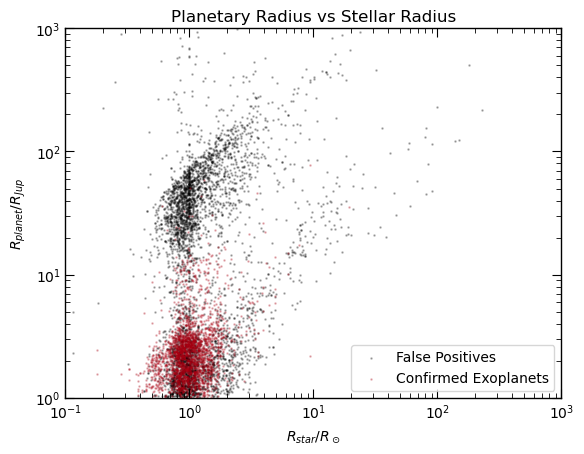

In [14]:
# Plot
fig = plt.figure()
ax = plt.gca()

ax.set_title('Planetary Radius vs Stellar Radius')
ax.set_xlabel("$R_{star}/R_\odot$")
ax.set_ylabel("$R_{planet}/R_{Jup}$")

ax.scatter(radiusStar_FalseP, radiusPlanet_FalseP, 
           s=0.75, 
           c='k', 
           alpha=0.25, 
           label="False Positives")

ax.scatter(radiusStar_conf, radiusPlanet_conf, 
           s=0.75, 
           c='#aa0011', 
           alpha=0.25, 
           label="Confirmed Exoplanets")
ax.legend()
ax.set_xscale('log')
ax.set_yscale('log')

There appears to be two large grouping of planetary radii in false positives. The confirmed planets all seem to be grouped around the same order of magnitude. This means that most of the confirmed planets should be around the size of Jupyter. 

Though there appears to be a large grouping of false positives around 10-100 times the size of jupyter, there seems to be a lack of confirmation in that reagion.
Jupyter is a large planet and is close to the limit of a brown dwarf star [1].

It is worth noting the linear relationship they seem to have. There appears to be two parallel lines extending from the groupings of the planetary radii. The physical significance of this was not looked into. Just very interesting.

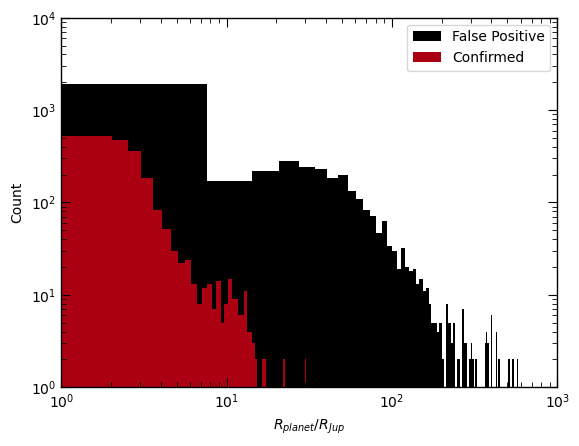

In [15]:
# Plot
fig = plt.figure()
ax = plt.gca()

ax.set_xlabel("$R_{planet}/R_{Jup}$")
ax.set_ylabel("Count")
ax.hist(radiusPlanet_FalseP, bins=150, alpha=1, color='k', label="False Positive")
ax.hist(radiusPlanet_conf, bins=150, alpha=1, color='#aa0011', label="Confirmed")

ax.legend()
ax.set_xscale('log')
ax.set_yscale('log')

A histogram was created to try and visualize this grouping more quantifyably. There is something weird going on with the counting though. Hence the weird bound conditions in the query.

The Conmirfmed exoplanets are all counted in the first "bump" in the histogram opposed to the hiher radius planets. A higher radius planet seems to be found to be a false positive.

### Question 3: Number of transit objects per the metilicity of the host star

**Background**

The metalicity of the star in this case refers to the ratio between Iron (Fe) and Hydrogen (H) at surface temperature. In the data, the metalicity is then normalized to the solar metalicity.

The stars metalicity also depends on the stars age and what part of it's life and generation it's in. The star's metalicity will increase with age and generation. An interseting pattern would be to find at what metalicity the most confirmed transit objects occur at.


**The Query**

The Query is similar to previous quesries and conditions but the column we want is just the metalicity where there is at least one confirmed planet orbiting it.

In [16]:
queryQ3_conf = """
SELECT ABS(so.koi_smet)
FROM Stellar_Objects AS so
WHERE so.kepid IN (SELECT kepid FROM koi_disposition
                    WHERE koi_disposition="CONFIRMED")
"""

In [17]:
# Execute MySQL queries
c.execute(queryQ3_conf)
queryQ3_conf_results = c.fetchall()

met_conf = np.array(queryQ3_conf_results)

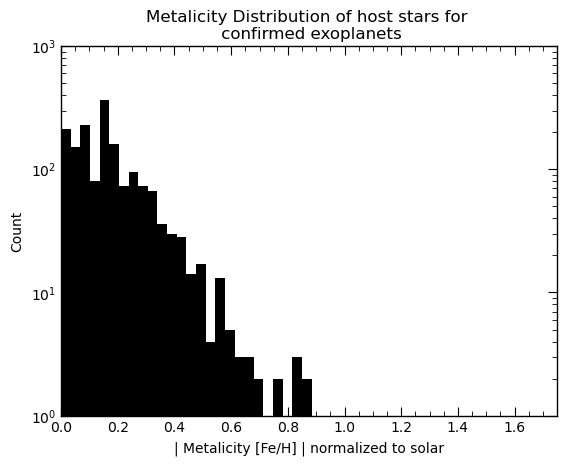

In [18]:
fig = plt.Figure()
ax = plt.gca()

ax.set_title("Metalicity Distribution of host stars for \n confirmed exoplanets")
ax.set_xlabel("| Metalicity [Fe/H] | normalized to solar")
ax.set_ylabel("Count")

ax.hist(met_conf, bins=50)
ax.set_yscale('log')

As seen, most of the metalicity of the stars with confirmed exoplanets are within a resonable range of our sun. This also lines up with the results found in part 1 in the HR diagram; where most stars with confirmed exoplanets occur in the solar neighborhood.

Lets use another SQL query to make sure this is the case using the AVG() and STD() aggregate Functions.

In [19]:
queryQ3_2 = """
SELECT AVG(ABS(koi_smet)), STD(ABS(koi_smet))
FROM Stellar_Objects AS so
WHERE so.kepid IN (SELECT kepid FROM koi_disposition
                    WHERE koi_disposition="CONFIRMED")
"""

# Execute MySQL queries
c.execute(queryQ3_2)
queryQ3_2_results = c.fetchall()

print("Average Metalicity:",queryQ3_2_results[0][0])
print("Std:",queryQ3_2_results[0][1])

Average Metalicity: 0.17305903380640078
Std: 0.14924098865069937


### Question 4: What sort of relationship exists between the period of orbit of the transit objcet and the radius of the star.

**Background**

The radius of the star and the period are both fairly easy to measure. Though the period is an important factor when considering habitial planets.

**The Query**

The Query as mentioned before in other questions, will need to include the CONFIRMED disposition, and an attribute from both the `stellar_objects` table and the `transit_properties` table.




In [20]:
queryQ4 = """
SELECT so.koi_smass, tp.koi_period
FROM Stellar_Objects AS so
RIGHT JOIN transit_properties AS tp
ON (so.kepid = tp.kepid)
WHERE so.kepid IN (SELECT kepid FROM koi_disposition
                    WHERE koi_disposition="CONFIRMED")
"""

queryQ4_2 = """
SELECT so.koi_smass, tp.koi_period
FROM Stellar_Objects AS so
RIGHT JOIN transit_properties AS tp
ON (so.kepid = tp.kepid)
WHERE so.kepid IN (SELECT kepid FROM koi_disposition
                    WHERE koi_disposition="FALSE POSITIVE")
"""

# Execute MySQL queries
c.execute(queryQ4)
queryQ4_results = c.fetchall()

# Execute MySQL queries_2
c.execute(queryQ4_2)
queryQ4_results_FP = c.fetchall()

In [21]:
# transpose the list and split
queryQ4_results_T= tuple(zip(*queryQ4_results))

smass_conf = np.array(queryQ4_results_T[0])
period_conf = np.array(queryQ4_results_T[1])

# transpose the list and split
queryQ4_results_FP_T= tuple(zip(*queryQ4_results_FP))

smass_FP = np.array(queryQ4_results_FP_T[0])
period_FP = np.array(queryQ4_results_FP_T[1])

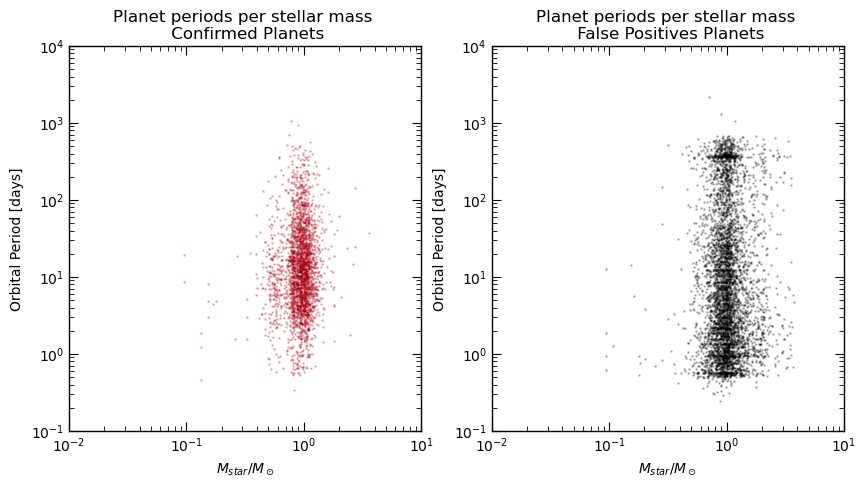

In [22]:
# Plot
fig = plt.figure(figsize=(10,5))

ax1 = plt.subplot(121)
ax1.set_title('Planet periods per stellar mass \n Confirmed Planets')
ax1.set_xlabel("$M_{star}/M_\odot$")
ax1.set_ylabel("Orbital Period [days]")

ax1.scatter(smass_conf, period_conf, 
           s=0.75, 
           c='#aa0011', 
           alpha=0.25, 
           label="Confirmed Planet periods")
ax1.set_xscale('log')
ax1.set_yscale('log')

ax2 = plt.subplot(122)
ax2.set_title('Planet periods per stellar mass \n False Positives Planets')
ax2.set_xlabel("$M_{star}/M_\odot$")
ax2.set_ylabel("Orbital Period [days]")

ax2.scatter(smass_FP, period_FP, 
           s=0.75, 
           c='k', 
           alpha=0.25, 
           label="False Positive Planet periods")

ax2.set_xscale('log')
ax2.set_yscale('log')

There is not a huge distribution of period related to the mass of the star. Most of the stars do appear within the solar neighbourhood never really leaving the same order of magnitude.

There is a slight gap in false positives around a period of 100 days, however, whether this is statstically significant, let alone physical is a question that still need to be answered.

Note again here that this is for each transit object not each unique star.

### Question 5: Where do most of the false positives occur when looking at the stellar radius and mass

**Background**

Similar to the other questions, this questions lends it's self onto finding a relationship between easily observed stellar parameters and relating that to a likely hood of, in this case, seeing a confirmed exoplanet.


**The Query**
The query will be similar to that in question 4 though with different attributes in the SELECT statment

In [23]:
queryQ5 = """
SELECT so.koi_srad, so.koi_smass
FROM Stellar_Objects AS so
WHERE so.kepid IN (SELECT kepid FROM koi_disposition
                    WHERE koi_disposition="CONFIRMED")
"""

queryQ5_2 = """
SELECT so.koi_srad, so.koi_smass
FROM Stellar_Objects AS so
WHERE so.kepid IN (SELECT kepid FROM koi_disposition
                    WHERE koi_disposition="FALSE POSITIVE")
"""

# Execute MySQL queries
c.execute(queryQ5)
queryQ5_results = c.fetchall()

# Execute MySQL queries_2
c.execute(queryQ5_2)
queryQ5_results_FP = c.fetchall()

In [24]:
# transpose the list and split
queryQ5_results_T= tuple(zip(*queryQ5_results))

srad_conf = np.array(queryQ5_results_T[0])
smass_conf = np.array(queryQ5_results_T[1])

# transpose the list and split
queryQ5_results_FP_T= tuple(zip(*queryQ5_results_FP))

srad_FP = np.array(queryQ5_results_FP_T[0])
smass_FP = np.array(queryQ5_results_FP_T[1])

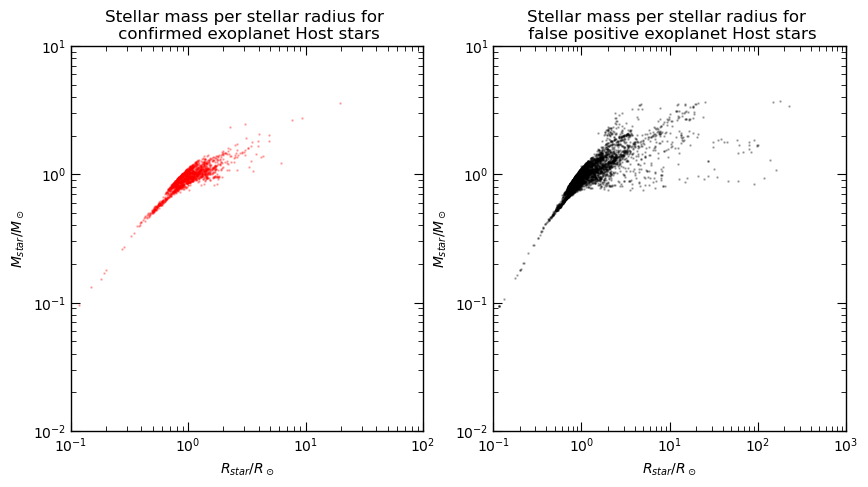

In [25]:
# Plot
fig = plt.figure(figsize=(10,5))

ax1 = plt.subplot(121)
ax1.set_title('Stellar mass per stellar radius for \n confirmed exoplanet Host stars')
ax1.set_xlabel("$R_{star}/R_\odot$")
ax1.set_ylabel("$M_{star}/M_\odot$")

ax1.scatter(srad_conf, smass_conf, 
           s=0.75, 
           c='r', 
           alpha=0.25, 
           label="Confirmed Planet periods")
ax1.set_xscale('log')
ax1.set_yscale('log')

ax2 = plt.subplot(122)
ax2.set_title('Stellar mass per stellar radius for \n false positive exoplanet Host stars')
ax2.set_xlabel("$R_{star}/R_\odot$")
ax2.set_ylabel("$M_{star}/M_\odot$")

ax2.scatter(srad_FP, smass_FP, 
           s=0.75, 
           c='k', 
           alpha=0.25, 
           label="False Positive Planet periods")

ax2.set_xscale('log')
ax2.set_yscale('log')

Again as we can see from inspection of the charts, the spread of the parameters is larger. We can more quantitavely see this using the STD aggregate function. 

This will take 1 query with a UNION.

In [26]:
queryQ5_3_1 = """
SELECT STD(so.koi_srad), STD(so.koi_smass)
FROM Stellar_Objects AS so
WHERE so.kepid IN (SELECT kepid FROM koi_disposition
                    WHERE koi_disposition="CONFIRMED")
UNION(SELECT STD(so.koi_srad), STD(so.koi_smass)
        FROM Stellar_Objects AS so
        WHERE so.kepid IN (SELECT kepid FROM koi_disposition
                            WHERE koi_disposition="FALSE POSITIVE"))
"""

In [27]:
c.execute(queryQ5_3_1)
result = c.fetchall()
print("For Confirmed Planets, the STD of stellar radius is:", result[0][0])
print("For Confirmed Planets, the STD of stellar mass is:", result[0][1])
print("For False Positive observations, the STD of stellar radius is:", result[1][0])
print("For False Positive observations, the STD of stellar mass is:", result[1][1])

For Confirmed Planets, the STD of stellar radius is: 0.7047924935841428
For Confirmed Planets, the STD of stellar mass is: 0.2329563636686024
For False Positive observations, the STD of stellar radius is: 7.763368617085193
For False Positive observations, the STD of stellar mass is: 0.4001630494056716


There appears to be a very large standard deviation in the false positive stellar radius observations. No statistical outliers were removed in cleaning. This could attribute to this large number.

### Question 6: get the average number of stars orbiting each of the harvard clssifications of stars.

**Background**

Here we will use the harvard spectral classification method based on the temperature.[3]

| Class | Temperature |
| ----- | ----------- |
|   O   |>30,000      | 
|   B   |10,000–30,000 K|
|   A   |7,500–10,000 K|
|   F   |6,000–7,500 K|
|   G   |5,200–6,000 K|
|   K   |3,700–5,200 K|
|   M   |2,400–3,700 K|

**The Query**

To retrive this information, We need to count the kepoi_names where the kepid corresponds to a star that has the correct temperature range for the wanted classification and has a confirmed disposition. 

We could use joins to connect all 7 classifications but the query would be long and complicated. Instead we will create a python loop that will loop through the wanted temperture ranges and add the counts to a list.

In [28]:
queryQ6 = """
SELECT COUNT(kepoi_name)
FROM Transit_Properties AS tp
WHERE kepid IN (SELECT kepid FROM Stellar_Objects WHERE (koi_steff>{} AND koi_steff<={}))
AND tp.kepid IN (SELECT kepid FROM koi_disposition WHERE koi_disposition="CONFIRMED")
"""

In [29]:
tempRanges = [(2400,3700),(3700,5200),(5200,6000),(6000,7500),(7500,10_000),(10_000,30_000), (30_000, 100_000)]
counts = []
for ran in tempRanges:
    c.execute(queryQ6.format(ran[0], ran[1]))
    counts.append(c.fetchall()[0][0])
print(counts)

[45, 646, 1422, 557, 2, 0, 0]


<BarContainer object of 7 artists>

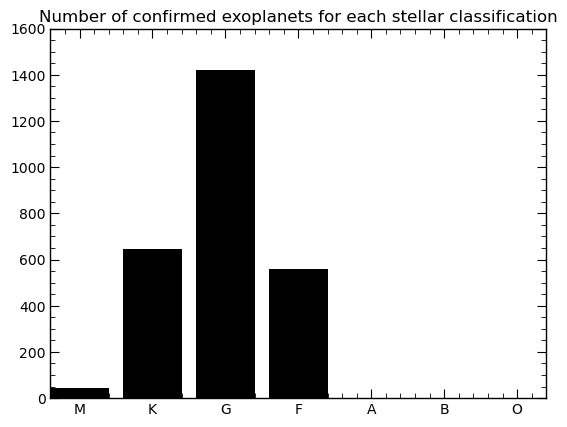

In [30]:
plt.title("Number of confirmed exoplanets for each stellar classification")
plt.bar(["M", "K",  "G", "F", "A", "B", "O"], counts)

Most confirmed exoplanets are around G stars. This also happens to be the same classification of the sun. Great!

### Question 7: What is the distribution of transit object tempertures for confirmed planets vs false positives. Does this have a connection to the semi-major-axis (SMA) of the orbit?

**Background**

The exoplanet temperature is important when finding earth like exoplanets. 

**The Query**
We need the transit property table as well as the koi_disposition table.

In [31]:
queryQ7 = """
SELECT koi_teq, koi_sma
FROM Transit_Properties AS tp
WHERE tp.kepid IN (SELECT kepid FROM koi_disposition WHERE koi_disposition="CONFIRMED")
"""

In [32]:
c.execute(queryQ7)
resultQ7 = c.fetchall()
temperatureSMA = np.array(tuple(zip(*resultQ7)))
print(temperatureSMA)

[[1.339e+03 2.048e+03 8.000e+02 ... 7.540e+02 3.650e+02 2.200e+02]
 [3.540e-02 3.760e-02 5.300e-02 ... 1.285e-01 2.950e-02 9.940e-01]]


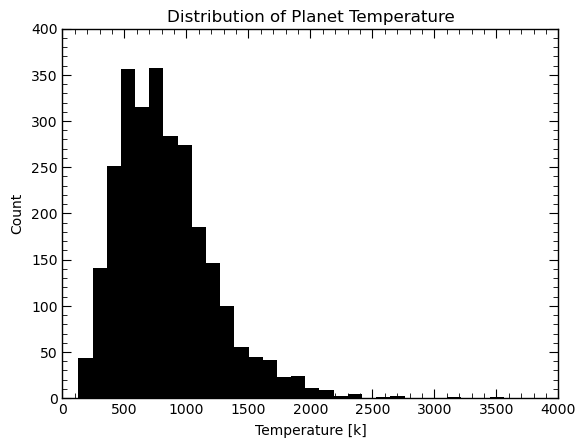

In [33]:
fig = plt.Figure()
ax = plt.gca()

ax.set_title("Distribution of Planet Temperature")
ax.set_xlabel("Temperature [k]")
ax.set_ylabel("Count")

ax.hist(temperatureSMA[0], bins=30)
plt.show()

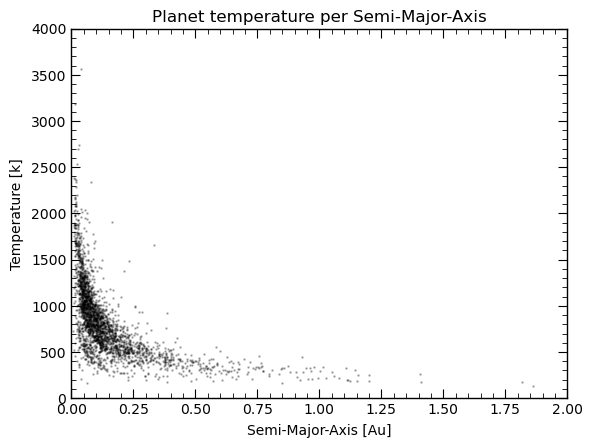

In [34]:
fig = plt.Figure()
ax = plt.gca()

ax.set_title("Planet temperature per Semi-Major-Axis")
ax.set_xlabel("Semi-Major-Axis [Au]")
ax.set_ylabel("Temperature [k]")

ax.scatter(temperatureSMA[1], temperatureSMA[0],
           s=0.75, 
           c='k', 
           alpha=0.25, 
           label="False Positive Planet periods")
plt.show()

There is a pretty clear inverse proportionality to the SMA and the temperature of the planet. This makes perfect sense as if the planet is farther away (orbits farther out),it should be colder. 

The trend is definitly not linear and falls off quite exponentially.

### Question 8: What is the relationship between the temperature of the star and the results in the previous question.

**Background**

The orbit of the star should not be all that matters. A larger, more massive star producing more heat, will have planets orbiting farther out that still have the same temperature as other planets that orbit closer to cooler stars.

**The Query**

The query will be similar but a join to the stellar table is needed.

In [35]:
queryQ8 = """
SELECT koi_teq, koi_sma, koi_steff
FROM Transit_Properties AS tp
LEFT JOIN Stellar_Objects AS so
ON tp.kepid=so.kepid
WHERE tp.kepid IN (SELECT kepid FROM koi_disposition WHERE koi_disposition="CONFIRMED")
"""

In [36]:
c.execute(queryQ8)
resultQ8 = c.fetchall()
resultQ8_T = np.array(tuple(zip(*resultQ8)))
print(resultQ8_T[:,:5])

[[1.339e+03 2.048e+03 8.000e+02 2.034e+03 1.515e+03]
 [3.540e-02 3.760e-02 5.300e-02 5.480e-02 4.400e-02]
 [5.820e+03 6.440e+03 4.778e+03 6.244e+03 5.795e+03]]


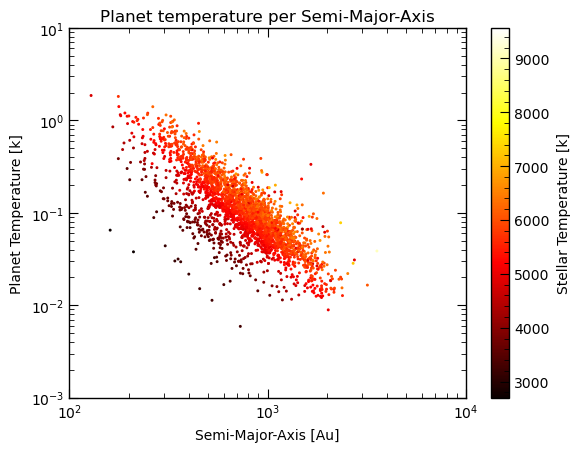

In [37]:
fig = plt.Figure()
ax = plt.gca()

ax.set_title("Planet temperature per Semi-Major-Axis")
ax.set_xlabel("Semi-Major-Axis [Au]")
ax.set_ylabel("Planet Temperature [k]")

plot = ax.scatter(resultQ8_T[0], resultQ8_T[1], 
                  c=resultQ8_T[2], cmap='hot', 
                  s=1.25)
plt.colorbar(plot, label="Stellar Temperature [k]")
ax.set_xscale('log')
ax.set_yscale('log')

This plot is similar to question 7, though it is logged and the stellar temperature is plotted. Cooler stars are seen to have confirmed exoplanets that orbit closer to them, while the hotter stars have planets orbiting farther away. 

The relationship between the Planet temperature and the stellar temperature are seen to be faily linear. Lets confirm this with another plot of just stellar and planetary temperatures.

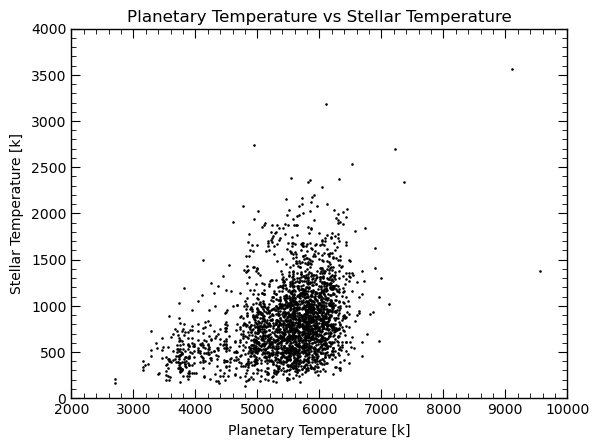

In [38]:
# Plot
fig = plt.figure()
ax = plt.gca()

ax.set_title('Planetary Temperature vs Stellar Temperature')
ax.set_xlabel("Planetary Temperature [k]")
ax.set_ylabel("Stellar Temperature [k]")

ax.scatter(resultQ8_T[2], resultQ8_T[0], 
           s=0.75, 
           c='k', 
           label="False Positives")
plt.show()

The plot seems to be failry grouped. The linear inspection above may not have been true to a meaningful degree. 

### Question 9: Does planet temperature and planet radius have a distinct pattern? Where are most of the confimed earth like planets in respect to these two parameters.

In [39]:
queryQ9 = """
SELECT koi_teq, koi_prad
FROM Transit_Properties AS tp
WHERE tp.kepid IN (SELECT kepid FROM koi_disposition WHERE koi_disposition="CONFIRMED")
"""

queryQ9_2 = """
SELECT koi_teq, koi_prad
FROM Transit_Properties AS tp
WHERE tp.kepid IN (SELECT kepid FROM koi_disposition WHERE koi_disposition="FALSE POSITIVE")
"""

In [40]:
c.execute(queryQ9)
resultQ9 = c.fetchall()
resultQ9_T = np.array(tuple(zip(*resultQ9)))

c.execute(queryQ9_2)
resultQ9_2 = c.fetchall()
resultQ9_2_T = np.array(tuple(zip(*resultQ9_2)))

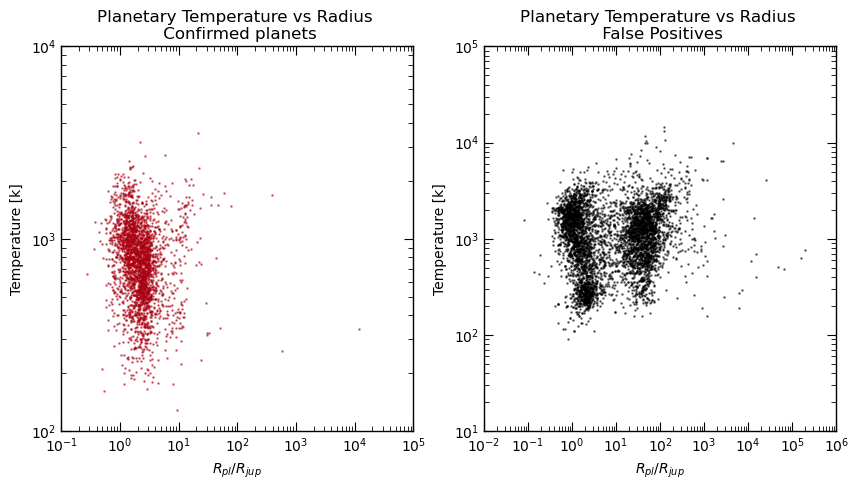

In [41]:
# Plot
fig = plt.figure(figsize=(10,5))

ax1 = plt.subplot(121)
ax1.set_title('Planetary Temperature vs Radius \n Confirmed planets')
ax1.set_xlabel("$R_{pl}/R_{jup}$")
ax1.set_ylabel("Temperature [k]")

ax1.scatter(resultQ9_T[1], resultQ9_T[0], 
           s=0.75, 
           c='#aa0011',
           alpha=0.5,
           label="False Positives")
ax1.set_xscale('log')
ax1.set_yscale('log')

ax2 = plt.subplot(122)
ax2.set_title('Planetary Temperature vs Radius \n False Positives')
ax2.set_xlabel("$R_{pl}/R_{jup}$")
ax2.set_ylabel("Temperature [k]")

ax2.scatter(resultQ9_2_T[1], resultQ9_2_T[0], 
           s=0.75, 
           c='k',
           alpha=0.5,
           label="False Positives")
ax2.set_xscale('log')
ax2.set_yscale('log')

plt.show()

There seems to be two groupings on Radius as before when comparing with stellar radius. The temperature does not seem to depend on the radius of the planet by inspection of the graph. 

Mostly just a couple of blobs on a screen. Again, not suprissingly the confirmed planets are gathered to the smaller radius (more similar to jupiter).

### Question 10: How many candidate transit objects have a radius, temperature, and a G host star?

This query will combine the results from what I believe are the more important parameters for an earth-like exoplanet. 

In [42]:
queryQ10_1 = """
SELECT COUNT(tp.kepoi_name)
FROM Transit_Properties AS tp
WHERE tp.kepid IN (SELECT kepid
					FROM koi_disposition 
                    WHERE koi_disposition="CANDIDATE")
"""

In [43]:
c.execute(queryQ10_1)
result10_1 = c.fetchone()
print(result10_1)

(2775,)


In [44]:
queryQ10 = """
SELECT COUNT(tp.kepoi_name)
FROM Transit_Properties AS tp
WHERE tp.kepid IN (SELECT kepid
					FROM koi_disposition 
                    WHERE koi_disposition="CANDIDATE")
	AND tp.kepid IN (SELECT kepid 
						FROM Stellar_Objects
                        WHERE (koi_steff>5200 AND koi_steff<=6000))
	AND (tp.koi_prad > 0 AND tp.koi_prad < 10)
	AND (tp.koi_teq > 500 AND tp.koi_teq < 1000)
"""

In [45]:
c.execute(queryQ10)
result10 = c.fetchone()
print(result10)

(529,)


Based on some inspected grouping from the other confirmed and false positive data, it would be resonable to assume that 529 candidate planets out of 2775 have a good chance of being confirmed as an exoplanet

In [46]:
db.close()

### References

[1] Prialnik, D. (2010). *An Introduction to the Theory of Stellar Structure and Evolution* (2nd ed.). Cambridge university Press.

[2] Grant R. Fowles, G. L. C. (2005). *Analytical Mechanics*. (S. D. Chris Hall, Rebecca Heider, Ed.) (7th ed.). David Harris.

[3] L. S. Sparke, J. S. Gallagher, I. (2007). *Galaxies in the Universe An Introduction* (2nd ed.). Cambridge university Press.

[4] NASA. Nasa exoplanet archive Cumulative kepler object of interest table, 2017. data retrieved from https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=koi.